In [2]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [3]:
!pip install patchify
!pip install segmentation-models


In [4]:
import os
import cv2
from PIL import Image
import numpy as np
import random
import json
import segmentation_models as sm
from patchify import patchify
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#PART 2
import tensorflow as tf
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate,BatchNormalization,Dropout,Lambda
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


Segmentation Models: using `tf.keras` framework.


In [5]:
dire = "Dataset"

In [6]:
image_patch_size = 256

In [7]:
image_dataset = []
mask_dataset = []
for tile_id in range(1,7):
    for image_id in range(1,20):
        image = cv2.imread(f'{dire}/Tile {tile_id}/images/image_part_00{image_id}.jpg',1)
        mask = cv2.imread(f'{dire}/Tile {tile_id}/masks/image_part_00{image_id}.png',1)

        if image is not None:

            size_x = (image.shape[1]//image_patch_size)*image_patch_size
            size_y = (image.shape[0]//image_patch_size)*image_patch_size

            image = Image.fromarray(image)
            image = image.crop((0,0,size_x,size_y))
            image = np.array(image)
            patched_images = patchify(image,(image_patch_size,image_patch_size,3),step = image_patch_size)

            for i in range(patched_images.shape[0]):
                for j in range(patched_images.shape[1]):
                    individual_image = patched_images[i,j,:,:]

                    individual_image = MinMaxScaler().fit_transform(individual_image.reshape(-1,individual_image.shape[-1])).reshape(individual_image.shape)
                    individual_image = individual_image[0]

                    image_dataset.append(individual_image)

            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, size_x, size_y))
            mask = np.array(mask)
            patched_masks = patchify(mask, (image_patch_size, image_patch_size, 3), step=image_patch_size)

            for i in range(patched_masks.shape[0]):
                for j in range(patched_masks.shape[1]):

                    individual_mask = patched_masks[i, j, :, :]
                    #individual_mask = MinMaxScaler().fit_transform(individual_mask.reshape(-1, individual_mask.shape[-1])).reshape(individual_mask.shape)
                    individual_mask = individual_mask[0]

                    mask_dataset.append(individual_mask)



In [8]:
print(len(image_dataset))
print(len(mask_dataset))

441
441


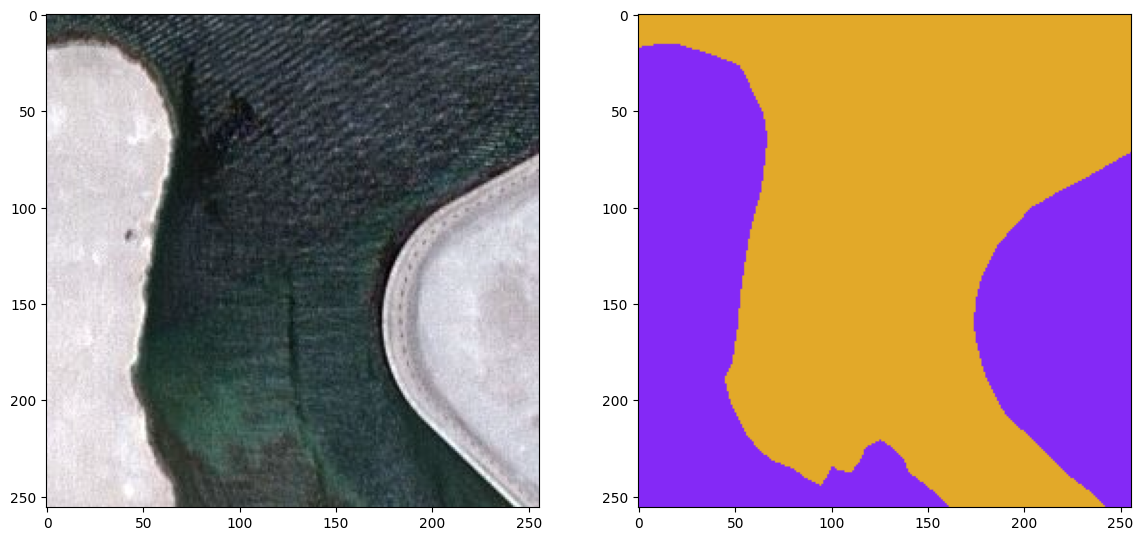

In [9]:
random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])


In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [12]:
mask_dataset_np = np.array(mask_dataset)
image_dataset_np = np.array(image_dataset)
labels = []
for i in range(mask_dataset_np.shape[0]):
  label = rgb_to_label(mask_dataset_np[i])
  labels.append(label)

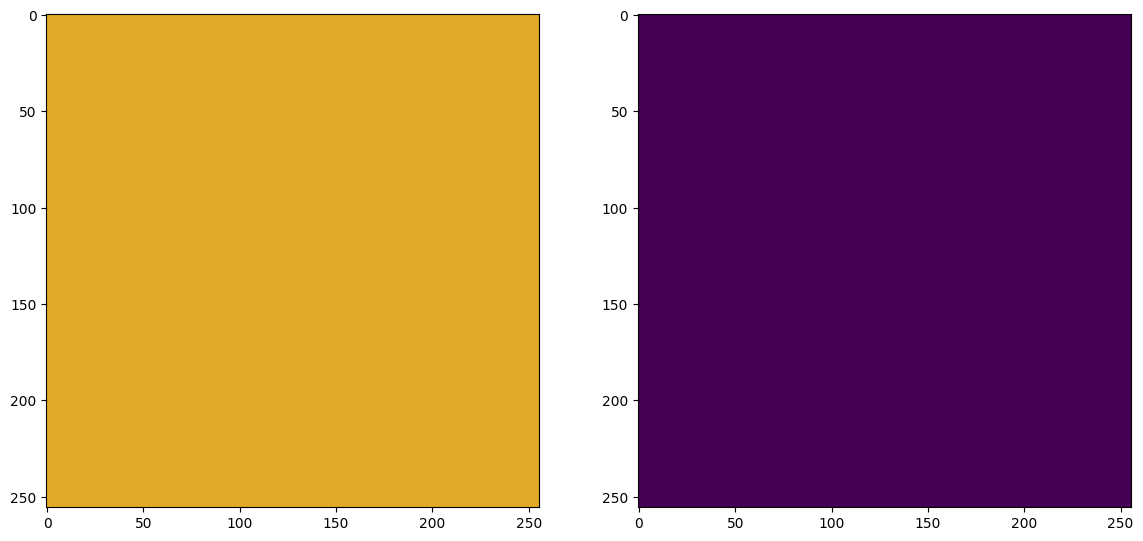

In [13]:
#np.expand_dims(labels,axis=3)

random_image_id = random.randint(0,len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(mask_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id])


In [14]:
total_classes = 6

In [15]:
#One hot encoded dataset
#For each pixel its label is represented as an array ex 3 is [0 0 1 0 0 0]
# 5 is [0 0 0 0 1 0]
labels_catagorical_dataset = to_categorical(labels,num_classes = total_classes)

In [16]:
X_train,X_test ,y_train,y_test = train_test_split(image_dataset_np,labels_catagorical_dataset,test_size=0.2,random_state=100)

In [17]:
def jaccard_coef(y_true,y_pred):
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat*y_pred_flat)
    final_coef_value = (intersection +1.0)/(tf.keras.backend.sum(y_true_flat)+tf.keras.backend.sum(y_pred_flat)-intersection+1.0)
    return final_coef_value

In [18]:
def multi_Unet_model(num_classes,image_height=256,image_width=256,image_channels=3):
    inputs  = Input((image_height,image_width,image_channels))

    source_inputs = inputs

    c1 = Conv2D(filters = 16,kernel_size = (3,3),activation="relu",kernel_initializer="he_normal",padding="same")(source_inputs)
    c1 = Dropout(rate=0.2)(c1) #Dropout 20% of the data from c1
    c1 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
    c2 = Dropout(rate=0.2)(c2) #Dropout 20% of the data from c1
    c2 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
    c3 = Dropout(rate=0.2)(c3) #Dropout 20% of the data from c1
    c3 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
    c4 = Dropout(rate=0.2)(c4) #Dropout 20% of the data from c1
    c4 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
    c5 = Dropout(rate=0.2)(c5) #Dropout 20% of the data from c1
    c5 = Conv2D(256,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)

    u6 = Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

    u7 = Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)


    u8 = Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)

    u9 = Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
    u9 = concatenate([u9,c1],axis=3)#NOTE axis changed
    c9 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)

    outputs = Conv2D(num_classes,(1,1),activation="softmax")(c9)
    model = Model(inputs =[inputs],outputs=[outputs])

    return model

In [19]:
metrics = ["accuracy",jaccard_coef]
model = multi_Unet_model(total_classes,256,256,3)

In [20]:
# model.get_config()

In [21]:
#Loss function (Focal loss)(Cross entropy loss)
wieghts = [0.166,0.166,0.166,0.166,0.166,0.166]
dice_loss = sm.losses.DiceLoss(class_weights=wieghts)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [22]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam",loss=total_loss,metrics=metrics)

In [23]:
# model.summary()

In [25]:
model_history = model.fit(X_train,y_train,batch_size=16,verbose=1,epochs=250,validation_data=(X_test,y_test),shuffle=False)


Epoch 1/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 631ms/step - accuracy: 0.6226 - jaccard_coef: 0.3503 - loss: 0.9773 - val_accuracy: 0.6836 - val_jaccard_coef: 0.4079 - val_loss: 0.9701
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 596ms/step - accuracy: 0.6553 - jaccard_coef: 0.3772 - loss: 0.9715 - val_accuracy: 0.6943 - val_jaccard_coef: 0.3935 - val_loss: 0.9652
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 597ms/step - accuracy: 0.6574 - jaccard_coef: 0.3892 - loss: 0.9684 - val_accuracy: 0.6862 - val_jaccard_coef: 0.4099 - val_loss: 0.9653
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 584ms/step - accuracy: 0.6728 - jaccard_coef: 0.4004 - loss: 0.9658 - val_accuracy: 0.7080 - val_jaccard_coef: 0.4347 - val_loss: 0.9604
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.6889 - jaccard_coef: 0.4163 - loss: 0.9630 - val_accuracy: 0.7230 - val_jaccard_coef: 0.4362 - val_loss: 0.9572
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 592ms/step - accuracy: 0.7003 - jaccard_coef: 0.4304 - lo

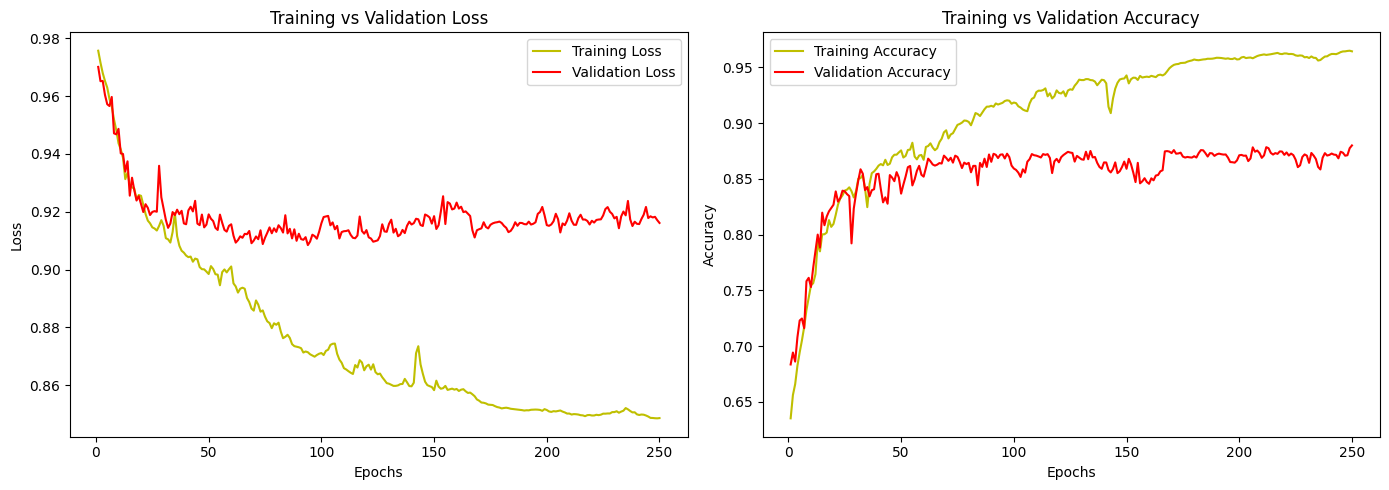

In [26]:
history_a = model_history

# Plot training and validation loss
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
acc = history_a.history['accuracy']
val_acc = history_a.history['val_accuracy']

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step


In [28]:
y_pred_label = np.argmax(y_pred,axis=3)


In [29]:
y_test_argmax = np.argmax(y_test,axis=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


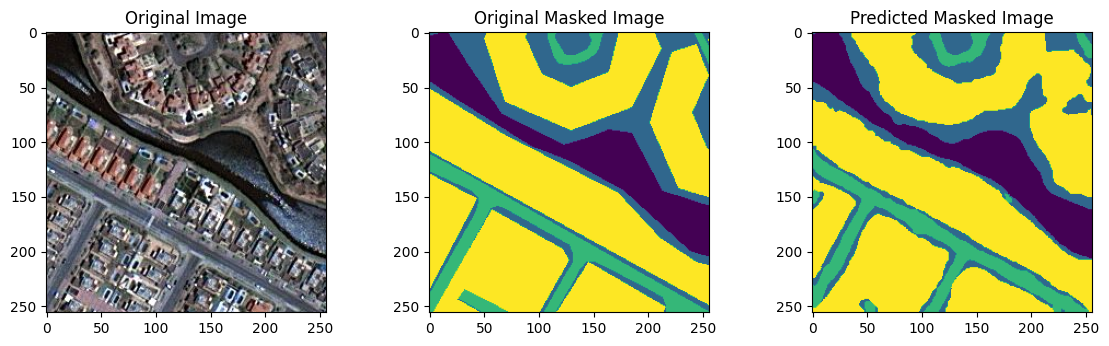

In [30]:
#Comparing Results
test_image_number = random.randint(0,len(y_pred_label))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image,0)
predication = model.predict(test_image_input)
predicted_image = np.argmax(predication,axis=3)

predicted_image = predicted_image[0,:,:]

plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)

plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image)

plt.subplot(233)
plt.title("Predicted Masked Image")
plt.imshow(predicted_image)


In [31]:
type(predicted_image)

numpy.ndarray

In [32]:
model.save("Unet_250.h5")